In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
import os
import pandas as pd
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50
import time
import datetime
import numpy as np
from IPython.display import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
##master = pd.read_csv(r"C:\Users\PC\Documents\ArbAlgo\data\bitmex_hist_data\large_data_2018-07-02_to_2018-09-04.csv")
#master = pd.read_csv(r"C:\Users\PC\Documents\ArbAlgo\data\bitmex_hist_data\large_data_2018-06-30_to_2018-09-12_today.csv")
#unnamed_cols = [x for x in list(master.columns) if "Unnamed" in x]
#try:
#    master = master.drop(unnamed_cols,axis=1)
#except:
#    None
#master.head()

In [8]:
start = datetime.datetime(2019,1,1).date() #(2018,9,21) earliest
end = datetime.datetime(2019,5,13).date()
#end = datetime.datetime.now().date()
#################################################
date = start
master = pd.DataFrame()
while date <= end:
    try:
        try:
            data = pd.read_csv(r"C:\Users\Jameshuckle\Dropbox\Bitcoin\ArbAlgo\data\deri_data\\"+str(date)+"_perp_fut"+".csv")
        except:
            data = pd.read_csv(r"C:\Users\Jameshuckle\Dropbox\Bitcoin\ArbAlgo\data\deri_data\\"+str(date)+"_perp_fut"+".zip")            
        master = pd.concat([master,data],sort=True)
        print(date)
        clear_output(wait=True)
        date = date+datetime.timedelta(days=1)
    except FileNotFoundError:
        print(date,"not found")
        date = date+datetime.timedelta(days=1)

## remove duplicates of bid ask prices (no real movement)
price_cols = ["bid_price_x","ask_price_x","bid_price_y","ask_price_y"]
shift_col_names = [x+"_shift" for x in price_cols]
dup_col_names = [x+"_dup" for x in price_cols]

master[shift_col_names] = master[price_cols].shift(1)

print("size before dup drop",len(master))
for col in price_cols:
    master[col+"_dup"] = master[col] - master[col+"_shift"]
master["dups"] = master[dup_col_names].sum(axis=1)
master = master[master["dups"] != 0]
master.drop(["dups"]+shift_col_names+dup_col_names,axis=1,inplace=True) 
print("size after dup drop",len(master))

## change column names to suit backtester
master.rename({'bid_price_x': 'bidPrice_x',
               'ask_price_x': 'askPrice_x',
               'bid_price_y': 'bidPrice_y',
               'ask_price_y': 'askPrice_y',
               'instrument_x': 'symbol_x',
               'instrument_y': 'symbol_y'},inplace=True,axis=1)
master.drop("my_utc_time",axis=1,inplace=True)
master = master.sort_values("timestamp")
master = master.reset_index(drop=True)

display(master.head())
master.tail()

size before dup drop 12873172
size after dup drop 1246185


,askPrice_x,askPrice_y,ask_size_x,ask_size_y,bidPrice_x,bidPrice_y,bid_size_x,bid_size_y,symbol_x,symbol_y,timestamp
0,3697.0,3631.5,555,91,3696.5,3630.5,2834,570,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 00:00:03.707000
1,3697.0,3632.5,2456,4245,3696.5,3630.5,3467,470,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 00:00:20.089000
2,3697.0,3632.0,2456,4080,3696.5,3630.5,3467,470,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 00:00:21.726000
3,3697.0,3632.5,2456,4244,3696.5,3630.5,3467,470,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 00:00:22.082000
4,3697.0,3632.0,2502,4080,3696.5,3630.5,5279,469,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 00:00:29.613000


,askPrice_x,askPrice_y,ask_size_x,ask_size_y,bidPrice_x,bidPrice_y,bid_size_x,bid_size_y,symbol_x,symbol_y,timestamp
1246180,7892.5,7897.5,401,2661,7892.25,7896.50,24825,100,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:08.688000
1246181,7892.5,7897.5,401,2661,7892.25,7896.25,24825,100,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:08.956000
1246182,7892.5,7897.5,401,2661,7892.25,7895.50,24825,755,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:09.073000
1246183,7892.5,7897.5,401,2661,7892.25,7893.00,24825,755,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:09.389000
1246184,7892.5,7897.5,401,2661,7892.25,7893.25,15131,755,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:09.567000


### delete known days of disruption on bitmex (downtimes with huuuge spreads)

In [9]:
#print(master.shape)
#try:
#    master["timestamp"] = pd.to_datetime(master["timestamp"])
#    #master = master[(master["timestamp"] < datetime.datetime(2018,8,22,0,0,0)) & (master["timestamp"] > datetime.datetime(2018,8,22,3,0,0))]
#    #master = master.reset_index()
#except:
#    None
#master.shape

### Add in moving average bands, and resample/reconstruct 1min bar data if needed

In [10]:
com_data2 = master #.copy()

com_data2["sell_perp"] = com_data2["bidPrice_x"] - com_data2["askPrice_y"]
com_data2["buy_perp"] = com_data2["askPrice_x"] - com_data2["bidPrice_y"]
com_data2["timestamp"] = pd.to_datetime(com_data2["timestamp"])

#### variables ####
data_type = "bars1m"

if data_type == "ticks":
    mov_avg = 2000
elif data_type == "bars1m":
    mov_avg = 150
    
margin = 0.1/100
## OR if using bollinger band ##
std_devs = 3.5 #2.5 roughly equivilent to 0.075 margin

taker = np.mean([0.05,0.075])/100
maker = np.mean([-0.025,-0.02])/100
fee = (taker+maker)
###################################
##workings out ##
#btc = 6720
#fee = btc*taker*2
#profit = btc*margin

if data_type == "ticks":
    ### this is the same calculation as
    spread_mid_avg = (com_data2["sell_perp"]+com_data2["buy_perp"])/2
    ### this one
    spread_mid_avg = ((com_data2["askPrice_x"] + com_data2["bidPrice_x"])/2) - ((com_data2["askPrice_y"] + com_data2["bidPrice_y"])/2)
    ###########################################################################
    com_data2["spread_mid_avg"] = spread_mid_avg
    ## now calc rolling spread mid
    com_data2["spread_mid_avg_rolling"] = spread_mid_avg.rolling(window=mov_avg, min_periods=mov_avg).mean()
    # shift only the moving average forward to account for look ahead bias
    com_data2["spread_mid_avg_rolling"] = com_data2["spread_mid_avg_rolling"].shift(1)
    ## used to calculate average fee price based on passive entry on ask_x then bid_x on exit and aggreassive entry on ask_y then bid_y on exit. Take the average
    com_data2["price_mid_avg"] = com_data2[["askPrice_x","bidPrice_x","askPrice_y","bidPrice_y"]].mean(axis=1)
    ## cleanup 
    com_data2 = com_data2.dropna(axis=0)
    com_data2 = com_data2.sort_values("timestamp")
    
    
elif data_type == "bars1m":
    bar_data = com_data2.set_index("timestamp",drop=True).copy()
    
    price_mid_avg = pd.Series(bar_data[["askPrice_x","bidPrice_x","askPrice_y","bidPrice_y"]].resample('1Min').last().ffill().mean(axis=1),name="price_mid_avg")
    perp_buy_avg = pd.Series(bar_data['buy_perp'].resample('1Min').last().ffill(),name = "perp_buy_avg")
    perp_sell_avg = pd.Series(bar_data['sell_perp'].resample('1Min').last().ffill(),name = "perp_sell_avg")
    
    ### combine 1min sampled data from buy and sell
    bar_data = pd.concat([perp_buy_avg, perp_sell_avg,price_mid_avg], axis=1)
    ## create spread mid avg and roll it
    bar_data["spread_mid_avg"] = (bar_data["perp_buy_avg"]+bar_data["perp_sell_avg"])/2
    bar_data["spread_mid_avg_rolling"] = bar_data["spread_mid_avg"].rolling(window=mov_avg, min_periods=mov_avg).mean()
    bar_data["mov_avg_speed"] = bar_data["spread_mid_avg_rolling"].diff()*mov_avg
    bar_data["mov_avg_speed"] = bar_data["mov_avg_speed"]/(price_mid_avg*(margin+fee))
    bar_data["mov_avg_speed"] = bar_data["mov_avg_speed"].rolling(window=10).mean()
    
    ## interestingly now combine the 1min data with the original tick data #####
    cols = ["mov_avg_speed","spread_mid_avg_rolling","price_mid_avg","spread_mid_avg"]
    com_data2 = com_data2.merge(bar_data[cols],how="outer",on="timestamp",sort=True)
    com_data2 = com_data2.sort_values("timestamp")
    ## Leaving the rolling average to permeate forward, we have alreadly shifted it forward one bar in the previous function to account for look ahead bias
    com_data2[cols] = com_data2[cols].ffill()
    ## drop the now dummy rows from the 1min data, as they are no longer helpful
    com_data2 = com_data2.dropna(axis=0,subset=["symbol_x"])
    ## just roll it forward one tick this time, as the close of the previous 1m bar will not be known until the open of the next bar, or just the next tick really
    com_data2["spread_mid_avg_rolling"] = com_data2["spread_mid_avg_rolling"].shift(1)
    
    
com_data2["sell_perp_band"] = com_data2["spread_mid_avg_rolling"] + ((com_data2["price_mid_avg"]*fee)+(com_data2["price_mid_avg"]*margin))
com_data2["sell_perp_band"] = (com_data2["sell_perp_band"]*2).round()/2
com_data2["buy_perp_band"] = com_data2["spread_mid_avg_rolling"]- ((com_data2["price_mid_avg"]*fee)+(com_data2["price_mid_avg"]*margin))
com_data2["buy_perp_band"] = (com_data2["buy_perp_band"]*2).round()/2

sell_perp_std = com_data2["sell_perp"].rolling(window=mov_avg, min_periods=mov_avg).std()
buy_perp_std = com_data2["buy_perp"].rolling(window=mov_avg, min_periods=mov_avg).std()

com_data2["sell_perp_boll"] = com_data2["spread_mid_avg_rolling"]+sell_perp_std*std_devs
com_data2["sell_perp_boll"] = (com_data2["sell_perp_boll"]*2).round()/2
com_data2["buy_perp_boll"] = com_data2["spread_mid_avg_rolling"]-buy_perp_std*std_devs
com_data2["buy_perp_boll"] = (com_data2["buy_perp_boll"]*2).round()/2

com_data2 = com_data2[1:]

del bar_data

print(com_data2.shape)
com_data2.tail()

(1246184, 21)


,askPrice_x,askPrice_y,ask_size_x,ask_size_y,bidPrice_x,bidPrice_y,bid_size_x,bid_size_y,symbol_x,symbol_y,timestamp,sell_perp,buy_perp,mov_avg_speed,spread_mid_avg_rolling,price_mid_avg,spread_mid_avg,sell_perp_band,buy_perp_band,sell_perp_boll,buy_perp_boll
1437501,7892.5,7897.5,401.0,2661.0,7892.25,7896.50,24825.0,100.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:08.688,-5.25,-4.00,-0.730673,3.104167,7893.875,-3.0,14.0,-8.0,16.5,-8.5
1437502,7892.5,7897.5,401.0,2661.0,7892.25,7896.25,24825.0,100.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:08.956,-5.25,-3.75,-0.730673,3.104167,7893.875,-3.0,14.0,-8.0,16.5,-9.0
1437503,7892.5,7897.5,401.0,2661.0,7892.25,7895.50,24825.0,755.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:09.073,-5.25,-3.00,-0.730673,3.104167,7893.875,-3.0,14.0,-8.0,16.5,-9.0
1437504,7892.5,7897.5,401.0,2661.0,7892.25,7893.00,24825.0,755.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:09.389,-5.25,-0.50,-0.730673,3.104167,7893.875,-3.0,14.0,-8.0,16.5,-8.5
1437505,7892.5,7897.5,401.0,2661.0,7892.25,7893.25,15131.0,755.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:09.567,-5.25,-0.75,-0.730673,3.104167,7893.875,-3.0,14.0,-8.0,16.5,-8.5


### shift working orders forward by time slip

In [11]:
working_levels_band = com_data2[["timestamp","askPrice_y","bidPrice_y","askPrice_x","bidPrice_x","sell_perp_band","buy_perp_band","sell_perp_boll","buy_perp_boll"]].copy()

# fixed bands
working_levels_band["temp_ask(band)"] = working_levels_band["askPrice_y"] + working_levels_band["sell_perp_band"]
working_levels_band["temp_bid(band)"] = working_levels_band["bidPrice_y"] + working_levels_band["buy_perp_band"]
working_levels_band["working_ask(band)"] = working_levels_band[["bidPrice_x","temp_ask(band)"]].max(axis=1) ### seems wierd, but if you set to ask, then it wil never trade!
working_levels_band["working_bid(band)"] = working_levels_band[["askPrice_x","temp_bid(band)"]].min(axis=1)

## boll bands
#working_levels_band["temp_ask(boll)"] = working_levels_band["askPrice_y"] + working_levels_band["sell_perp_boll"]
#working_levels_band["temp_bid(boll)"] = working_levels_band["bidPrice_y"] + working_levels_band["buy_perp_boll"]
#working_levels_band["working_ask(boll)"] = working_levels_band[["askPrice_x","temp_ask(boll)"]].max(axis=1)
#working_levels_band["working_bid(boll)"] = working_levels_band[["bidPrice_x","temp_bid(boll)"]].min(axis=1)

working_levels_band["timestamp"] = working_levels_band["timestamp"]+datetime.timedelta(seconds=0.5)

working_levels_band = working_levels_band[["timestamp","working_bid(band)","working_ask(band)"]]#"working_bid(boll)","working_ask(boll)"]]
print(com_data2.shape)
com_data2 = com_data2.merge(working_levels_band,on="timestamp",how="outer",sort=True)
print(com_data2.shape)
com_data2 = com_data2.ffill()

del working_levels_band

print(com_data2.shape)
display(com_data2.head())
com_data2.tail()

(1246184, 21)
(2491363, 23)
(2491363, 23)


,askPrice_x,askPrice_y,ask_size_x,ask_size_y,bidPrice_x,bidPrice_y,bid_size_x,bid_size_y,symbol_x,symbol_y,timestamp,sell_perp,buy_perp,mov_avg_speed,spread_mid_avg_rolling,price_mid_avg,spread_mid_avg,sell_perp_band,buy_perp_band,sell_perp_boll,buy_perp_boll,working_bid(band),working_ask(band)
0,3697.0,3632.5,2456.0,4245.0,3696.5,3630.5,3467.0,470.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 00:00:20.089,64.0,66.5,NaN,NaN,3664.5,64.5,NaN,NaN,NaN,NaN,NaN,NaN
1,3697.0,3632.5,2456.0,4245.0,3696.5,3630.5,3467.0,470.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 00:00:20.589,64.0,66.5,NaN,NaN,3664.5,64.5,NaN,NaN,NaN,NaN,3697.0,3696.5
2,3697.0,3632.0,2456.0,4080.0,3696.5,3630.5,3467.0,470.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 00:00:21.726,64.5,66.5,NaN,NaN,3664.5,64.5,NaN,NaN,NaN,NaN,3697.0,3696.5
3,3697.0,3632.5,2456.0,4244.0,3696.5,3630.5,3467.0,470.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 00:00:22.082,64.0,66.5,NaN,NaN,3664.5,64.5,NaN,NaN,NaN,NaN,3697.0,3696.5
4,3697.0,3632.5,2456.0,4244.0,3696.5,3630.5,3467.0,470.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 00:00:22.226,64.0,66.5,NaN,NaN,3664.5,64.5,NaN,NaN,NaN,NaN,3697.0,3696.5


,askPrice_x,askPrice_y,ask_size_x,ask_size_y,bidPrice_x,bidPrice_y,bid_size_x,bid_size_y,symbol_x,symbol_y,timestamp,sell_perp,buy_perp,mov_avg_speed,spread_mid_avg_rolling,price_mid_avg,spread_mid_avg,sell_perp_band,buy_perp_band,sell_perp_boll,buy_perp_boll,working_bid(band),working_ask(band)
2491358,7892.5,7897.5,401.0,2661.0,7892.25,7893.00,24825.0,755.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:09.456,-5.25,-0.50,-0.730673,3.104167,7893.875,-3.0,14.0,-8.0,16.5,-8.5,7888.25,7911.5
2491359,7892.5,7897.5,401.0,2661.0,7892.25,7893.25,15131.0,755.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:09.567,-5.25,-0.75,-0.730673,3.104167,7893.875,-3.0,14.0,-8.0,16.5,-8.5,7888.25,7911.5
2491360,7892.5,7897.5,401.0,2661.0,7892.25,7893.25,15131.0,755.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:09.573,-5.25,-0.75,-0.730673,3.104167,7893.875,-3.0,14.0,-8.0,16.5,-8.5,7887.50,7911.5
2491361,7892.5,7897.5,401.0,2661.0,7892.25,7893.25,15131.0,755.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:09.889,-5.25,-0.75,-0.730673,3.104167,7893.875,-3.0,14.0,-8.0,16.5,-8.5,7885.00,7911.5
2491362,7892.5,7897.5,401.0,2661.0,7892.25,7893.25,15131.0,755.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:10.067,-5.25,-0.75,-0.730673,3.104167,7893.875,-3.0,14.0,-8.0,16.5,-8.5,7885.25,7911.5


### work out bid ask spread of each market, then shift that information forward about 1 second (latency)

In [12]:
bid_ask = com_data2[["timestamp","askPrice_y","bidPrice_y","askPrice_x","bidPrice_x"]].copy()

# spreads
bid_ask["perp_bid_ask"] = bid_ask["askPrice_x"] - bid_ask["bidPrice_x"]
bid_ask["fut_bid_ask"] = bid_ask["askPrice_y"] - bid_ask["bidPrice_y"]

bid_ask["timestamp"] = bid_ask["timestamp"]+datetime.timedelta(seconds=0.2)
bid_ask = bid_ask[["timestamp","perp_bid_ask","fut_bid_ask"]]
com_data2 = com_data2.merge(bid_ask,on="timestamp",how="outer",sort=True)

cols = list(com_data2.columns)
cols.remove("perp_bid_ask")
com_data2 = com_data2.ffill()
com_data2.reset_index(inplace=True,drop=True)

del bid_ask

print(com_data2.shape)
com_data2.tail()

(4969419, 25)


,askPrice_x,askPrice_y,ask_size_x,ask_size_y,bidPrice_x,bidPrice_y,bid_size_x,bid_size_y,symbol_x,symbol_y,timestamp,sell_perp,buy_perp,mov_avg_speed,spread_mid_avg_rolling,price_mid_avg,spread_mid_avg,sell_perp_band,buy_perp_band,sell_perp_boll,buy_perp_boll,working_bid(band),working_ask(band),perp_bid_ask,fut_bid_ask
4969414,7892.5,7897.5,401.0,2661.0,7892.25,7893.25,15131.0,755.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:09.773,-5.25,-0.75,-0.730673,3.104167,7893.875,-3.0,14.0,-8.0,16.5,-8.5,7887.50,7911.5,0.25,4.25
4969415,7892.5,7897.5,401.0,2661.0,7892.25,7893.25,15131.0,755.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:09.889,-5.25,-0.75,-0.730673,3.104167,7893.875,-3.0,14.0,-8.0,16.5,-8.5,7885.00,7911.5,0.25,4.25
4969416,7892.5,7897.5,401.0,2661.0,7892.25,7893.25,15131.0,755.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:10.067,-5.25,-0.75,-0.730673,3.104167,7893.875,-3.0,14.0,-8.0,16.5,-8.5,7885.25,7911.5,0.25,4.25
4969417,7892.5,7897.5,401.0,2661.0,7892.25,7893.25,15131.0,755.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:10.089,-5.25,-0.75,-0.730673,3.104167,7893.875,-3.0,14.0,-8.0,16.5,-8.5,7885.25,7911.5,0.25,4.25
4969418,7892.5,7897.5,401.0,2661.0,7892.25,7893.25,15131.0,755.0,BTC-PERPETUAL,BTC-28JUN19,2019-05-13 21:02:10.267,-5.25,-0.75,-0.730673,3.104167,7893.875,-3.0,14.0,-8.0,16.5,-8.5,7885.25,7911.5,0.25,4.25


In [13]:
#com_data2[:10000].plot(x="timestamp",y=["working_ask(band)","working_bid(band)","askPrice_x","bidPrice_x"],color=("b","b","r","g"),figsize=(30,15))

### Check size of data

In [14]:
com_data2.shape

(4969419, 25)

### select new size of data

In [15]:
#start = 0
#sample_size = int(len(seg)/90)
#
#end = min(len(seg),start+sample_size)
#seg = seg[start:end]


#seg = seg[int(len(seg)/2):len(seg)]


com_data2.dropna(axis=0,inplace=True)
com_data2.reset_index(drop=True,inplace=True)
print(com_data2.shape)

seg = com_data2
seg.head(5)

(4965944, 25)


,askPrice_x,askPrice_y,ask_size_x,ask_size_y,bidPrice_x,bidPrice_y,bid_size_x,bid_size_y,symbol_x,symbol_y,timestamp,sell_perp,buy_perp,mov_avg_speed,spread_mid_avg_rolling,price_mid_avg,spread_mid_avg,sell_perp_band,buy_perp_band,sell_perp_boll,buy_perp_boll,working_bid(band),working_ask(band),perp_bid_ask,fut_bid_ask
0,3681.5,3622.0,1500.0,98.0,3680.0,3621.5,120.0,267.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 02:40:24.194,58.0,60.0,-1.791038,63.046667,3652.125,57.25,68.0,58.0,72.5,54.0,3679.0,3690.0,0.5,0.5
1,3681.0,3622.0,20.0,98.0,3680.0,3621.5,120.0,267.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 02:40:24.389,58.0,59.5,-1.791038,62.931667,3652.125,57.25,68.0,58.0,72.0,54.0,3679.0,3690.0,0.5,0.5
2,3681.0,3622.0,20.0,98.0,3680.0,3621.5,120.0,267.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 02:40:24.394,58.0,59.5,-1.791038,62.931667,3652.125,57.25,68.0,58.0,72.0,54.0,3679.0,3690.0,1.5,0.5
3,3681.0,3622.0,20.0,98.0,3680.0,3621.5,120.0,267.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 02:40:24.589,58.0,59.5,-1.791038,62.931667,3652.125,57.25,68.0,58.0,72.0,54.0,3679.0,3690.0,1.0,0.5
4,3681.0,3623.5,20.0,18.0,3680.0,3622.0,120.0,8.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 02:40:24.614,56.5,59.0,-1.791038,62.931667,3652.125,57.25,68.0,58.0,72.5,54.0,3679.0,3690.0,1.0,0.5


## remove times where the exchange was down

In [16]:
print(len(seg))
try:
    bad_data = (seg["timestamp"] > datetime.datetime(2018,8,22,0,0,0)) & (seg["timestamp"] < datetime.datetime(2018,8,22,3,0,0))
    bad_data = bad_data[bad_data == True]
    if len(bad_data)>1:
        print("dropping")
        seg1 = seg.drop(bad_data.index,axis=0)
        seg1.reset_index(inplace=True)
    print(len(seg))
except:
    None

4965944
4965944


## Backtest

In [17]:
def dont_quote(side,band_type,get,index):
    trade = True
    ### variables ######
    perp_bid_ask = 160
    fut_bid_ask = 160
    mov_avg_speed = 3
    max_buy_band = 25
    min_sell_band = -25
    #perp_bid_ask_avg = perp_bid_ask * 1.5
    #fut_bid_ask_avg = fut_bid_ask * 1.5
    #sample_secs = 1
    #########################
    
    #time_sample = seg[(seg["timestamp"] >= row["timestamp"]-datetime.timedelta(seconds=sample_secs)) & (seg["timestamp"] <= row["timestamp"])]
    #max_perp_buy_spread = time_sample["buy_perp_"+band_type].max()
    #min_perp_sell_spread = time_sample["sell_perp_"+band_type].min()
    
    ### do we meet out current and average bid_ask spread parameters?
    if get[index,"perp_bid_ask"] >= perp_bid_ask and get[index,"fut_bid_ask"] >= fut_bid_ask:
        trade=False
        
    if side == "buy" and get[index,"mov_avg_speed"] <= -mov_avg_speed:
        trade=False
    elif side == "sell" and get[index,"mov_avg_speed"] >= mov_avg_speed:
        trade=False
   
        #if side == "buy":
        #    ## is price band too high/low
        #    if row["buy_perp_"+band_type] < max_buy_band:
        #        return True
        #    
        #elif side == "sell":
        #    ## is price band too high/low
        #    if row["sell_perp_"+band_type] > min_sell_band:
        #        return True
                
    return trade   

In [18]:
##### variables ##########################
slippage = 0.5
band_type = "band" #"boll"
time_slip = datetime.timedelta(seconds=0.05) 
############################################

trades = {}
buy = {"trade":False}
sell = {"trade":False}
per = 0
end=False

skip_first_bar = True
get = seg.at
for index in seg.index:
#for index,row in seg.iterrows():
    if skip_first_bar == True:
        skip_first_bar = False
        continue
    ### calculate running draw down #########
    if buy["trade"]==True:
        dd = get[index,"buy_perp"] - buy["entry"]
        if dd < buy["max_dd"]:
            buy["max_dd"] = dd
            
    elif sell["trade"]==True:
        dd = sell["entry"] - get[index,"sell_perp"]
        if dd < sell["max_dd"]:
            sell["max_dd"] = dd 
    ############################################
    ## conditions are right to trade   
    ## If we get a buy trade ####
    if get[index,"askPrice_x"]<=get[index,"working_bid("+band_type+")"] and get[index-1,"askPrice_x"] > get[index,"askPrice_x"]: # make sure that the ask has actively traded through the band, not just future market moving bands through
        quote = dont_quote("buy",band_type,get,index)
        if quote == True:
            if buy["trade"]==False:
                ## set a price on main data
                ## limit order fill at band price 
                perp_buy_leg = get[index,"working_bid("+band_type+")"]
                ## see if fut market is still there as market fill will not be instantanious
                lag = 1
                while True:
                    ## if the next timestamp along is bigger than perp_time + time it takes order to fill (time_slip),then you can be reasonably sure that you would have hit
                    ## a market that is still at the same price (as we have filtered out only tick moves in this data), however, if there are many ticks quickly after
                    ## then keep cycling through until you find the last tick the was AFTER the lagged order, and take the price before it as the future price fill
                    ## add slippage to this market order
                    ###if we are at the end of the dataset, then terminate
                    if index+lag >= len(seg)-1:
                        end = True
                        break
                    ########################################################
                    if get[index+lag,"timestamp"] > get[index,"timestamp"]+time_slip:
                        fut_sell_leg = get[index+lag-1,"bidPrice_y"]-slippage
                        lag=0
                        break
                    else:
                        lag+=1 
                if end ==True:
                    print("ending")
                    break
                    
                calc_buy_entry = perp_buy_leg-fut_sell_leg
                get[index,"buy_spread_price"] = calc_buy_entry            
                buy = dict(trade = True,
                           entry = calc_buy_entry,
                           price = get[index,"askPrice_x"],
                           target_size = get[index,"sell_perp_"+band_type]-get[index,"buy_perp_"+band_type],
                           time = get[index,"timestamp"],
                           max_dd = 0,
                           perp_bid_ask = get[index,"perp_bid_ask"],
                           fut_bid_ask = get[index,"fut_bid_ask"],
                           mov_avg_speed = round(get[index,"mov_avg_speed"],1))
                
                
                if sell["trade"] == True:
                    sell["trade"]=False
                    # calculcate a few useful things
                    revenue = sell["entry"]-buy["entry"]
                    comms = (sell["price"]*maker)+(buy["price"]*taker)
                    profit = revenue-comms
                    trades[index] = dict(initial_side = "sell",
                                         buy_entry = buy["entry"],
                                         sell_entry = sell["entry"],
                                         revenue = revenue,
                                         comms = comms,
                                         profit = profit,
                                         profit_percent = profit/sell["price"]*100,
                                         target_size = sell["target_size"],
                                         revenue_of_target = revenue/sell["target_size"],
                                         open_time = sell["time"],
                                         close_time = buy["time"],
                                         time_in_trade = buy["time"]-sell["time"],
                                         max_dd = sell["max_dd"],
                                         dd_of_target = sell["max_dd"]/sell["target_size"],
                                         perp_bid_ask = sell["perp_bid_ask"],
                                         fut_bid_ask =sell["fut_bid_ask"],
                                         mov_avg_speed = sell["mov_avg_speed"])
                                    
                                  
                                  
    ## If we get a sell trade ####        
    elif get[index,"bidPrice_x"]>= get[index,"working_ask("+band_type+")"] and get[index-1,"bidPrice_x"] < get[index,"bidPrice_x"]: # make sure that the bid has actively traded through the band, not just future market moving bands
        quote = dont_quote("sell",band_type,get,index)
        if quote == True:
            if sell["trade"]==False:
                ## set a price on main data
                ## limit order fill at band price
                perp_sell_leg = get[index,"working_ask("+band_type+")"]
                ## see if fut market is still there as market fill will not be instantanious
                lag = 1
                while True:
                    ## if the next timestamp along is bigger than perp_time + time it takes order to fill (time_slip),then you can be reasonably sure that you would have hit
                    ## a market that is still at the same price (as we have filtered out only tick moves in this data), however, if there are many ticks quickly after
                    ## then keep cycling through until you find the last tick the was AFTER the lagged order, and take the price before it as the future price fill
                    ## add slippage to this market order
                    ###if we are at the end of the dataset, then terminate
                    if index+lag >= len(seg)-1:
                        end = True
                        break
                    if get[index+lag,"timestamp"] > get[index,"timestamp"]+time_slip:
                        fut_buy_leg = get[index+lag-1,"askPrice_y"]+slippage
                        lag=0
                        break
                    else:
                        lag+=1
                if end ==True:
                    print("ending")
                    break
                    
                calc_sell_entry = perp_sell_leg-fut_buy_leg
                get[index,"sell_spread_price"] = calc_sell_entry
                sell = dict(trade = True,
                           entry = calc_sell_entry,
                           price = get[index,"bidPrice_x"],
                           target_size = get[index,"sell_perp_"+band_type]-get[index,"buy_perp_"+band_type],
                           time = get[index,"timestamp"],
                           max_dd = 0,
                           perp_bid_ask = get[index,"perp_bid_ask"],
                           fut_bid_ask = get[index,"fut_bid_ask"],
                           mov_avg_speed = round(get[index,"mov_avg_speed"],1))
                
                if buy["trade"] == True:
                    buy["trade"]=False
                    # calculcate a few useful things
                    revenue = sell["entry"]-buy["entry"]
                    comms = (buy["price"]*maker)+(sell["price"]*taker)
                    profit = revenue-comms
                    trades[index] = dict(initial_side = "buy",
                                         buy_entry = buy["entry"],
                                         sell_entry = sell["entry"],
                                         revenue = revenue,
                                         comms = comms,
                                         profit = profit,
                                         profit_percent = profit/buy["price"]*100,
                                         target_size = buy["target_size"],
                                         revenue_of_target = revenue/buy["target_size"],
                                         open_time = buy["time"],
                                         close_time = sell["time"],
                                         time_in_trade = sell["time"]-buy["time"],
                                         max_dd = buy["max_dd"],
                                         dd_of_target = buy["max_dd"]/buy["target_size"],
                                         perp_bid_ask = buy["perp_bid_ask"],
                                         fut_bid_ask = buy["fut_bid_ask"],
                                         mov_avg_speed = buy["mov_avg_speed"])
    
    if index == 0:
        print("start")
    elif index % int(len(seg)/1000) == 0:
        clear_output(wait=True)
        print(str(round(per,1))+"%","complete")
        
        per +=0.1

print(len(trades))
#trades                

99.9% complete
163


## copy and creates trades dataframe from trades dictionary

In [19]:
trades1 = pd.DataFrame(trades).transpose()
trades1["time_in_trade"] = trades1["time_in_trade"] / datetime.timedelta(minutes=1) # convert into minutes
trades1[['buy_entry', 'sell_entry', 'revenue', 'comms', 'profit', 'profit_percent', 'target_size', 'revenue_of_target','time_in_trade', 'max_dd', 'dd_of_target']] = \
trades1[['buy_entry', 'sell_entry', 'revenue', 'comms', 'profit', 'profit_percent', 'target_size', 'revenue_of_target','time_in_trade', 'max_dd', 'dd_of_target']].astype(float)

trades1.head()

,buy_entry,close_time,comms,dd_of_target,fut_bid_ask,initial_side,max_dd,mov_avg_speed,open_time,perp_bid_ask,profit,profit_percent,revenue,revenue_of_target,sell_entry,target_size,time_in_trade
22239,82.0,2019-01-01 18:35:07.992000,1.441050,-1.904762,0.5,sell,-20.0,0.6,2019-01-01 08:30:44.248000,1.5,-17.441050,-0.468279,-16.0,-1.523810,66.0,10.5,604.395733
22509,82.0,2019-01-01 18:35:35.433000,1.449225,-0.550000,1.5,buy,-5.5,-0.1,2019-01-01 18:35:07.992000,3,-3.449225,-0.094590,-2.0,-0.200000,80.0,10.0,0.457350
26087,76.0,2019-01-01 19:59:57.388000,1.492913,-0.750000,4,sell,-7.5,-0.1,2019-01-01 18:35:35.433000,2,2.507087,0.069037,4.0,0.400000,80.0,10.0,84.365917
36970,76.0,2019-01-01 23:19:00.568000,1.515275,-0.333333,1,buy,-3.5,-0.9,2019-01-01 19:59:57.388000,0.5,7.984725,0.216037,9.5,0.904762,85.5,10.5,199.053000
57389,90.5,2019-01-02 09:00:45.464000,1.527000,-1.190476,0.5,sell,-12.5,1,2019-01-01 23:19:00.568000,4,-6.527000,-0.173822,-5.0,-0.476190,85.5,10.5,581.748267


## Join trades (not neccesery if you already computed buy and sell price, but is nice to do)

In [20]:
seg1 = seg.join(trades1,lsuffix="_dup")
del seg
seg1.drop(["perp_bid_ask","fut_bid_ask"],axis=1)
seg1.head()

,askPrice_x,askPrice_y,ask_size_x,ask_size_y,bidPrice_x,bidPrice_y,bid_size_x,bid_size_y,symbol_x,symbol_y,timestamp,sell_perp,buy_perp,mov_avg_speed_dup,spread_mid_avg_rolling,price_mid_avg,spread_mid_avg,sell_perp_band,buy_perp_band,sell_perp_boll,buy_perp_boll,working_bid(band),working_ask(band),perp_bid_ask_dup,fut_bid_ask_dup,sell_spread_price,buy_spread_price,buy_entry,close_time,comms,dd_of_target,fut_bid_ask,initial_side,max_dd,mov_avg_speed,open_time,perp_bid_ask,profit,profit_percent,revenue,revenue_of_target,sell_entry,target_size,time_in_trade
0,3681.5,3622.0,1500.0,98.0,3680.0,3621.5,120.0,267.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 02:40:24.194,58.0,60.0,-1.791038,63.046667,3652.125,57.25,68.0,58.0,72.5,54.0,3679.0,3690.0,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3681.0,3622.0,20.0,98.0,3680.0,3621.5,120.0,267.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 02:40:24.389,58.0,59.5,-1.791038,62.931667,3652.125,57.25,68.0,58.0,72.0,54.0,3679.0,3690.0,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3681.0,3622.0,20.0,98.0,3680.0,3621.5,120.0,267.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 02:40:24.394,58.0,59.5,-1.791038,62.931667,3652.125,57.25,68.0,58.0,72.0,54.0,3679.0,3690.0,1.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3681.0,3622.0,20.0,98.0,3680.0,3621.5,120.0,267.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 02:40:24.589,58.0,59.5,-1.791038,62.931667,3652.125,57.25,68.0,58.0,72.0,54.0,3679.0,3690.0,1.0,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3681.0,3623.5,20.0,18.0,3680.0,3622.0,120.0,8.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 02:40:24.614,56.5,59.0,-1.791038,62.931667,3652.125,57.25,68.0,58.0,72.5,54.0,3679.0,3690.0,1.0,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ad-hoc analysis

In [21]:
#mad_trade = trades1[trades1["revenue_of_target"]<-6]
#mad_trade
#view = seg1[seg1["target_size"]>1]
#view.iloc[0:5,18:]

## Chart high and low, and performance statistics
### Histograms of:
* % target 
* max_dd 
* time in trade 
* profit% *revenue

count    163.000000
mean      -1.204728
std       11.475311
min     -115.565217
25%       -0.113636
50%        0.227273
75%        0.503299
max        1.428571
Name: revenue_of_target, dtype: float64

count     163.000000
mean      -23.208589
std       106.968627
min     -1353.000000
25%       -16.500000
50%        -8.750000
75%        -4.000000
max        -0.500000
Name: max_dd, dtype: float64

count    163.000000
mean      -1.603689
std        7.122454
min      -90.200000
25%       -1.198686
50%       -0.602564
75%       -0.302489
max       -0.025000
Name: dd_of_target, dtype: float64

count      163.000000
mean      1170.385858
std       4674.905360
min          0.056633
25%         64.551708
50%        225.683850
75%        600.867333
max      44516.977150
Name: time_in_trade, dtype: float64

count    163.000000
mean      -0.376252
std        3.204220
min      -32.534548
25%       -0.071321
50%        0.023271
75%        0.100880
max        0.343136
Name: profit_percent, dtype: float64

count     163.000000
mean      -17.332961
std       148.434661
min     -1349.677637
25%        -3.113587
50%         1.188675
75%         4.840619
max        18.036088
Name: profit, dtype: float64

count     163.000000
mean      -15.305215
std       148.407293
min     -1347.500000
25%        -1.500000
50%         3.250000
75%         6.625000
max        21.000000
Name: revenue, dtype: float64



-------------------------
chart lows: -82.25
chart highs: 147.5
-------------------------
number of trades: 163
days tested: 132.8
avg # RT's (buy-sell,buy-sell) per day: 1.0
avg size target band RT $: 15.5
avg gross profit per RT $: -15.31
avg comms per RT $: 2.03
avg profit per RT $: -17.33
profit per RT %: -0.376
total profit %: -61.29
daily return %: -0.5
yearly return(0 leverage, notional) %: -182.0
yearly return(0 leverage, 2.5x notional capital) %: -73.0






array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023FF0E7F160>]], dtype=object)

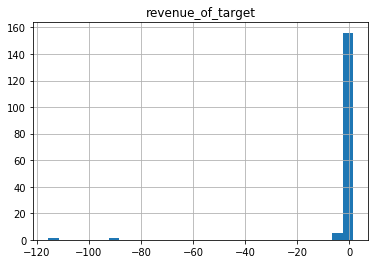

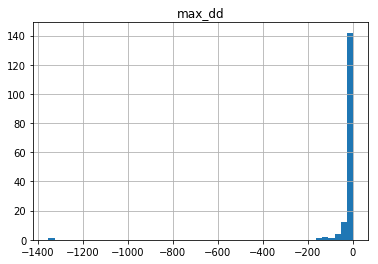

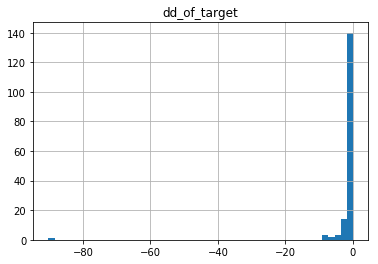

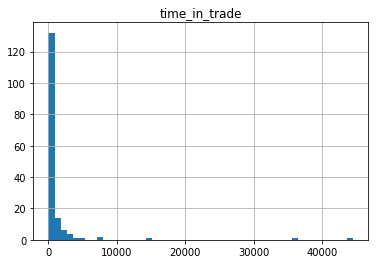

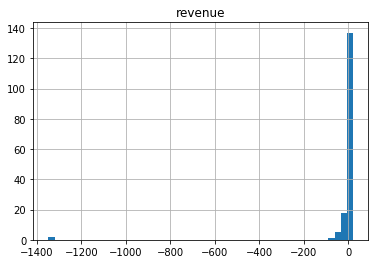

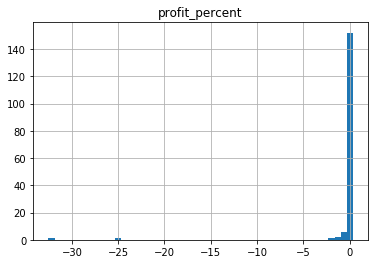

In [22]:
display(trades1["revenue_of_target"].describe())
trades1.hist("revenue_of_target",bins=30)
print()

display(trades1["max_dd"].describe())
trades1.hist("max_dd",bins=50)
print()

display(trades1["dd_of_target"].describe())
trades1.hist("dd_of_target",bins=50)
print()

display(trades1["time_in_trade"].describe())
trades1.hist("time_in_trade",bins=50)
print()

profit_per = trades1["profit_percent"].describe()
display(profit_per)
print("\n")

profit = trades1["profit"].describe()
display(profit)
print("\n")

display(trades1["revenue"].describe())
trades1.hist("revenue",bins=50)
print()
print()
print("-------------------------")
print("chart lows:",seg1["sell_perp"].min())
print("chart highs:",seg1["buy_perp"].max())
print("-------------------------")
trades = int(profit["count"])
print("number of trades:",trades)

date_range = round(float((seg1["timestamp"].iloc[len(seg1)-1] - seg1["timestamp"].iloc[0])/datetime.timedelta(days=1)),1)
print("days tested:",date_range)

trades_per_day = round(trades/date_range/2,0)
print("avg # RT's (buy-sell,buy-sell) per day:",trades_per_day)

target_size = round((seg1["sell_perp_"+band_type].mean() - seg1["buy_perp_"+band_type].mean()),1)
print("avg size target band RT $:",target_size)

gross_profit = round(trades1["revenue"].describe()["mean"],2)
print("avg gross profit per RT $:",gross_profit)

av_dollar_comms = round(trades1["comms"].describe()["mean"],2)
print("avg comms per RT $:",av_dollar_comms)

av_dollar_profit = round(trades1["profit"].describe()["mean"],2)
print("avg profit per RT $:",av_dollar_profit)

profit_pt = round(profit_per["mean"],3)
print("profit per RT %:",profit_pt)

total_perc_profit = round(trades*profit_pt,2)
print("total profit %:",total_perc_profit)

daily_return = round(total_perc_profit/date_range,1)
print("daily return %:",daily_return)
print("yearly return(0 leverage, notional) %:",round(daily_return*365,0))
print("yearly return(0 leverage, 2.5x notional capital) %:",round(daily_return*365/2.5,0))

print("\n")
print("\n")

trades1.hist("profit_percent",bins=50)

## Profit vs entry price of spread
### Is selling low numbers and buying high numbers worth it?

average perp/fut spread price 35
average buy trade entry price 40
average sell trade entry price 24


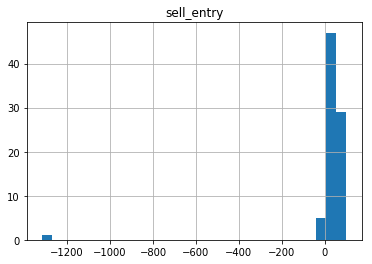

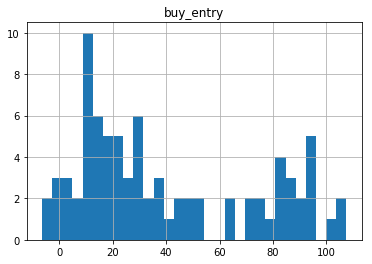

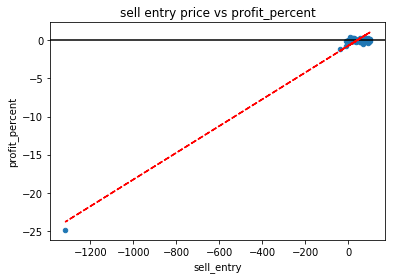

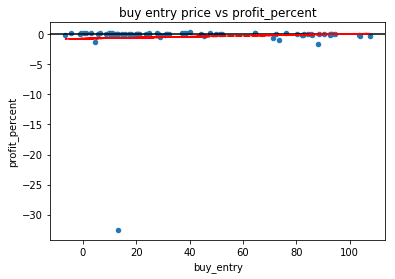

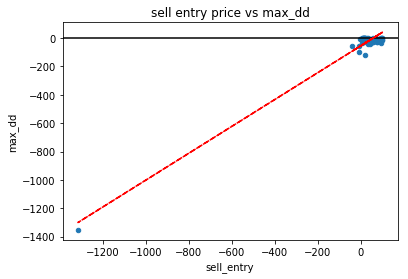

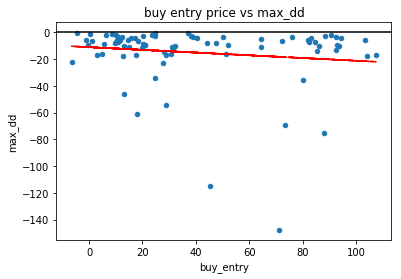

In [23]:
trades2 = trades1.copy()

buy_trades = trades2[trades2["initial_side"]=="buy"]
sell_trades = trades2[trades2["initial_side"]=="sell"]

sell_trades.hist("sell_entry",bins =30)
buy_trades.hist("buy_entry",bins =30)

print("average perp/fut spread price",round(seg1["spread_mid_avg_rolling"].mean()))
print("average buy trade entry price",round(buy_trades["buy_entry"].mean()))
print("average sell trade entry price",round(sell_trades["sell_entry"].mean()))

for variable in ["profit_percent","max_dd"]:
    ### plot sell trades as a function of how far out the spread is ##
    pl1 = sell_trades.plot.scatter(x="sell_entry",y=variable)
    pl1.axhline(y=0,color="black")
    plt.title("sell entry price vs "+variable)
    # calc the trendline
    x = sell_trades["sell_entry"]
    y = sell_trades[variable]
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    pl1.plot(x,p(x),"r--")
    # the line equation:
    #print("y=%.6fx+(%.6f)"%(z[0],z[1]))
    
    ### plot buy trades as a function of how far out the spread is ##
    pl1 = buy_trades.plot.scatter(x="buy_entry",y=variable)
    pl1.axhline(y=0,color="black")
    plt.title("buy entry price vs "+variable)
    # calc the trendline
    x = buy_trades["buy_entry"]
    y = buy_trades[variable]
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    pl1.plot(x,p(x),"r--")
    # the line equation:
    #print("y=%.6fx+(%.6f)"%(z[0],z[1]))
   

#trades2.head(50)

## Profit vs entry price - binned

Text(0.5,1,'sum profit at buy entry')

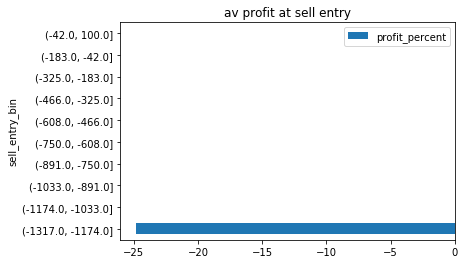

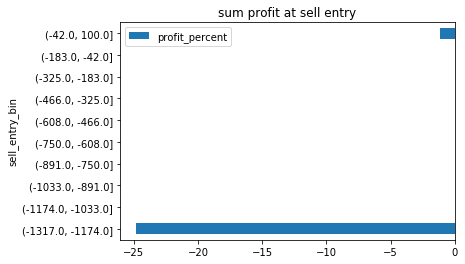

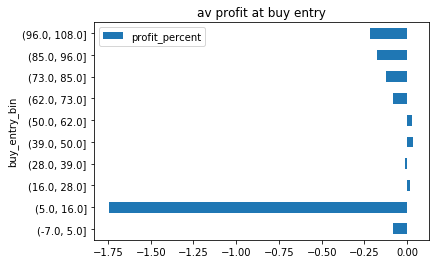

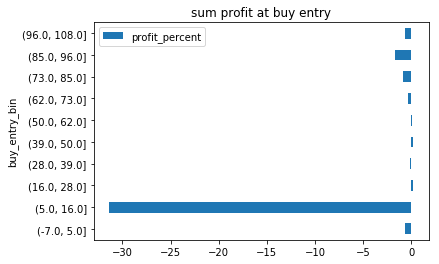

In [24]:
sell_trades = sell_trades.copy()
buy_trades = buy_trades.copy()

# group by sell price avg ###
sell_trades["sell_entry_bin"] = pd.cut(x = sell_trades["sell_entry"],bins = 10, precision=0) #[x for x in range(-400,250) if x%50==0]
sell_entry_group = sell_trades.groupby("sell_entry_bin").mean()
sell_entry_group.plot.barh(y="profit_percent")
plt.title("av profit at sell entry")

# group by sell price sum ###
sell_trades["sell_entry_bin"] = pd.cut(x = sell_trades["sell_entry"],bins = 10,precision=0)
sell_entry_group = sell_trades.groupby("sell_entry_bin").sum()
sell_entry_group.plot.barh(y="profit_percent")
plt.title("sum profit at sell entry")

# group by buy price avg ###
buy_trades["buy_entry_bin"] = pd.cut(x = buy_trades["buy_entry"],bins = 10,precision=0)
buy_entry_group = buy_trades.groupby("buy_entry_bin").mean()
buy_entry_group.plot.barh(y="profit_percent")
plt.title("av profit at buy entry")

# group by buy price sum ###
buy_trades["buy_entry_bin"] = pd.cut(x = buy_trades["buy_entry"],bins = 10,precision=0)
buy_entry_group = buy_trades.groupby("buy_entry_bin").sum()
buy_entry_group.plot.barh(y="profit_percent")
plt.title("sum profit at buy entry")

## Profit vs bid_ask spread at time of entry

average perp bid_ask generally 0.45
average fut bid_ask generally 1.18
average perp bid_ask at time of trade 1.42
average fut bid_ask at time of trade 1.76


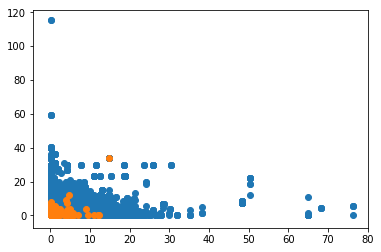

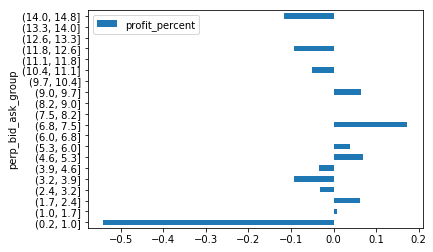

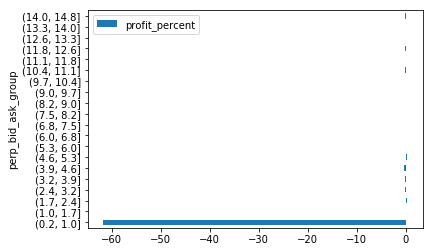

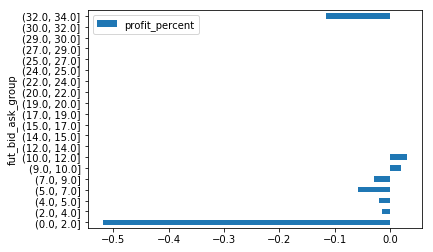

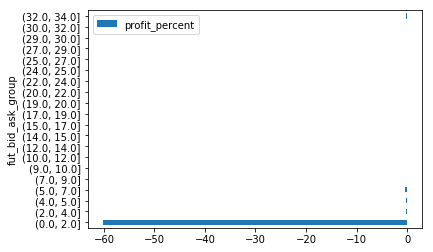

In [25]:
trades30 = trades2.copy()

print("average perp bid_ask generally",round(seg1["perp_bid_ask_dup"].mean(),2))
print("average fut bid_ask generally",round(seg1["fut_bid_ask_dup"].mean(),2))
print("average perp bid_ask at time of trade",round(trades30["perp_bid_ask"].mean(),2))
print("average fut bid_ask at time of trade",round(trades30["fut_bid_ask"].mean(),2))

#display(seg1[seg1["fut_bid_ask_dup"]>150])

seg1 = seg1[seg1["perp_bid_ask_dup"]>0]
plt.scatter(seg1["perp_bid_ask_dup"],seg1["fut_bid_ask_dup"])
plt.scatter(trades30["perp_bid_ask"],trades30["fut_bid_ask"])

trades30["perp_bid_ask_group"] = pd.cut(trades30["perp_bid_ask"],bins=20,precision=0)
trades30["fut_bid_ask_group"] = pd.cut(trades30["fut_bid_ask"],bins=20,precision=0)

perp_bid_ask_avg_group = trades30.groupby("perp_bid_ask_group").mean()
perp_bid_ask_sum_group = trades30.groupby("perp_bid_ask_group").sum()

fut_bid_ask_avg_group = trades30.groupby("fut_bid_ask_group").mean()
fut_bid_ask_sum_group = trades30.groupby("fut_bid_ask_group").sum()

perp_bid_ask_avg_group.plot.barh(y = "profit_percent")
perp_bid_ask_sum_group.plot.barh(y = "profit_percent")
fut_bid_ask_avg_group.plot.barh(y = "profit_percent")
fut_bid_ask_sum_group.plot.barh(y = "profit_percent")

## Profit vs hour of the day

Text(0.5,1,'total profit per trade each hour')

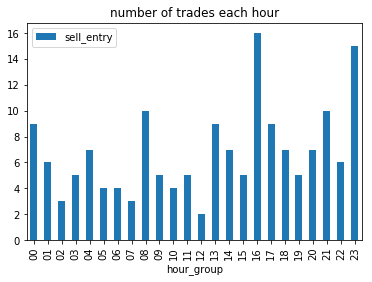

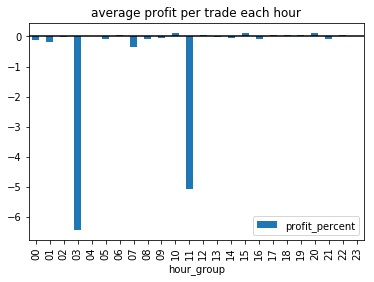

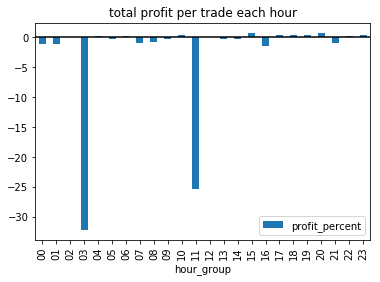

In [26]:
trades3 = trades2.copy()
## group by time fo day (hour) ###
trades3["hour_group"] = pd.to_datetime(trades3["open_time"].dt.hour)
trades3["hour_group"] = trades3["hour_group"].astype(str).str[-2:]

hour_count_group = trades3.groupby(["hour_group"]).count()
hour_avg_group = trades3.groupby(["hour_group"]).mean()
hour_sum_group = trades3.groupby(["hour_group"]).sum()

hour_count_group.plot.bar(y="sell_entry")
plt.title("number of trades each hour")

p2 = hour_avg_group.plot.bar(y="profit_percent")
p2.axhline(y=0,color="black")
plt.title("average profit per trade each hour")

p3 =hour_sum_group.plot.bar(y="profit_percent")
p3.axhline(y=0,color="black")
plt.title("total profit per trade each hour")

## Profit vs day of week
### Monday = 0, Sunday = 6

Text(0.5,1,'total profit each day')

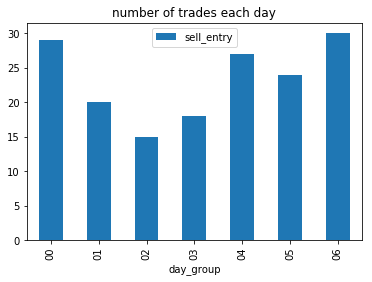

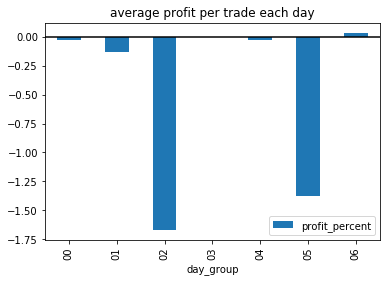

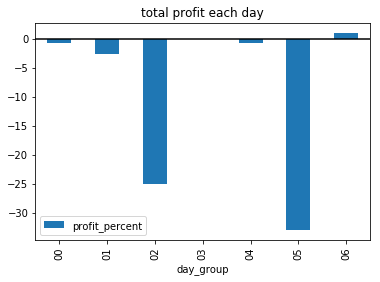

In [27]:
trades4 = trades2.copy()
## group by time fo day (hour) ###
trades4["day_group"] = pd.to_datetime(trades3["open_time"].dt.dayofweek)
trades4["day_group"] = trades4["day_group"].astype(str).str[-2:]

day_count_group = trades4.groupby(["day_group"]).count()
day_avg_group = trades4.groupby(["day_group"]).mean()
day_sum_group = trades4.groupby(["day_group"]).sum()

day_count_group.plot.bar(y="sell_entry")
plt.title("number of trades each day")

p2 = day_avg_group.plot.bar(y="profit_percent")
p2.axhline(y=0,color="black")
plt.title("average profit per trade each day")

p3 =day_sum_group.plot.bar(y="profit_percent")
p3.axhline(y=0,color="black")
plt.title("total profit each day")

In [28]:
trades3.head()

,buy_entry,close_time,comms,dd_of_target,fut_bid_ask,initial_side,max_dd,mov_avg_speed,open_time,perp_bid_ask,profit,profit_percent,revenue,revenue_of_target,sell_entry,target_size,time_in_trade,hour_group
22239,82.0,2019-01-01 18:35:07.992000,1.441050,-1.904762,0.5,sell,-20.0,0.6,2019-01-01 08:30:44.248000,1.5,-17.441050,-0.468279,-16.0,-1.523810,66.0,10.5,604.395733,08
22509,82.0,2019-01-01 18:35:35.433000,1.449225,-0.550000,1.5,buy,-5.5,-0.1,2019-01-01 18:35:07.992000,3,-3.449225,-0.094590,-2.0,-0.200000,80.0,10.0,0.457350,18
26087,76.0,2019-01-01 19:59:57.388000,1.492913,-0.750000,4,sell,-7.5,-0.1,2019-01-01 18:35:35.433000,2,2.507087,0.069037,4.0,0.400000,80.0,10.0,84.365917,18
36970,76.0,2019-01-01 23:19:00.568000,1.515275,-0.333333,1,buy,-3.5,-0.9,2019-01-01 19:59:57.388000,0.5,7.984725,0.216037,9.5,0.904762,85.5,10.5,199.053000,19
57389,90.5,2019-01-02 09:00:45.464000,1.527000,-1.190476,0.5,sell,-12.5,1,2019-01-01 23:19:00.568000,4,-6.527000,-0.173822,-5.0,-0.476190,85.5,10.5,581.748267,23


## Profit vs time to expiry (equity curve)

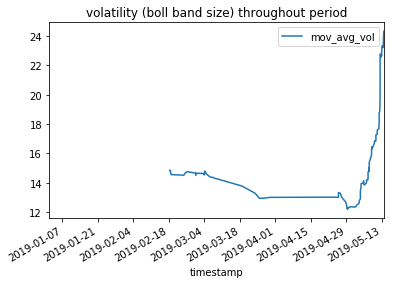

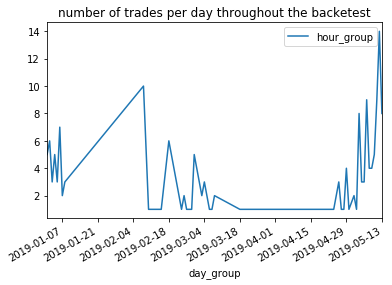

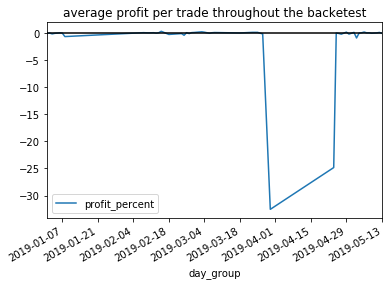

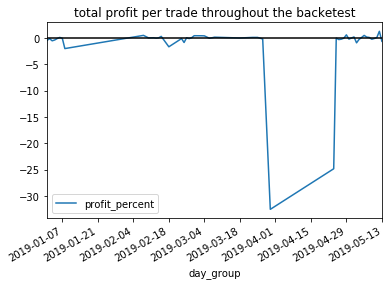

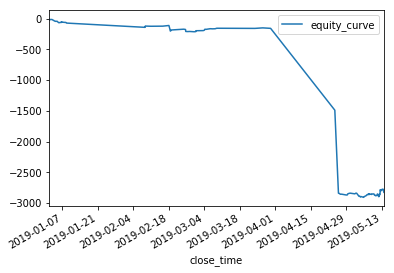

In [29]:
seg1["volatility"] = seg1["sell_perp_boll"] - seg1["buy_perp_boll"]
trades_vol = seg1.loc[trades3.index,:]
trades_vol["mov_avg_vol"] = trades_vol["volatility"].rolling(50).mean()
trades_vol.plot(x="timestamp",y="mov_avg_vol",title="volatility (boll band size) throughout period")

## group by days to see trend over months ###
trades3["day_group"] = pd.to_datetime(trades2["open_time"].dt.date)
day_count_group = trades3.groupby(["day_group"]).count()
day_avg_group = trades3.groupby(["day_group"]).mean()
day_sum_group = trades3.groupby(["day_group"]).sum()

day_count_group.plot(y="hour_group")
plt.title("number of trades per day throughout the backetest")

p2 = day_avg_group.plot(y="profit_percent")
p2.axhline(y=0,color="black")
plt.title("average profit per trade throughout the backetest")

p3 =day_sum_group.plot(y="profit_percent")
p3.axhline(y=0,color="black")
plt.title("total profit per trade throughout the backetest")
#
## equity curve
#display(trades3)
trades3["cum_profit"] = trades3["profit"].cumsum()
trades3["equity_curve"] = trades3["cum_profit"]
trades3.plot(x="close_time",y="equity_curve")

## Profit/ max_dd vs moving average speed?

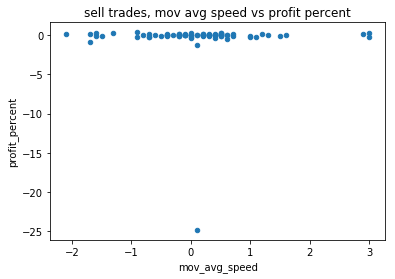

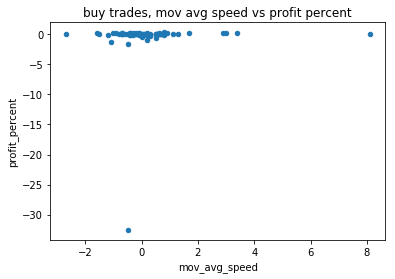

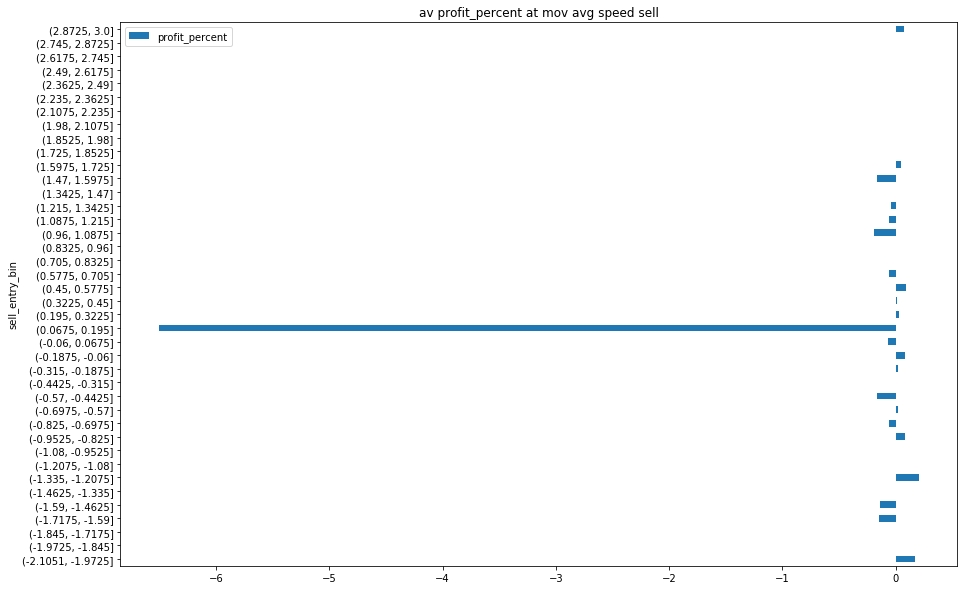

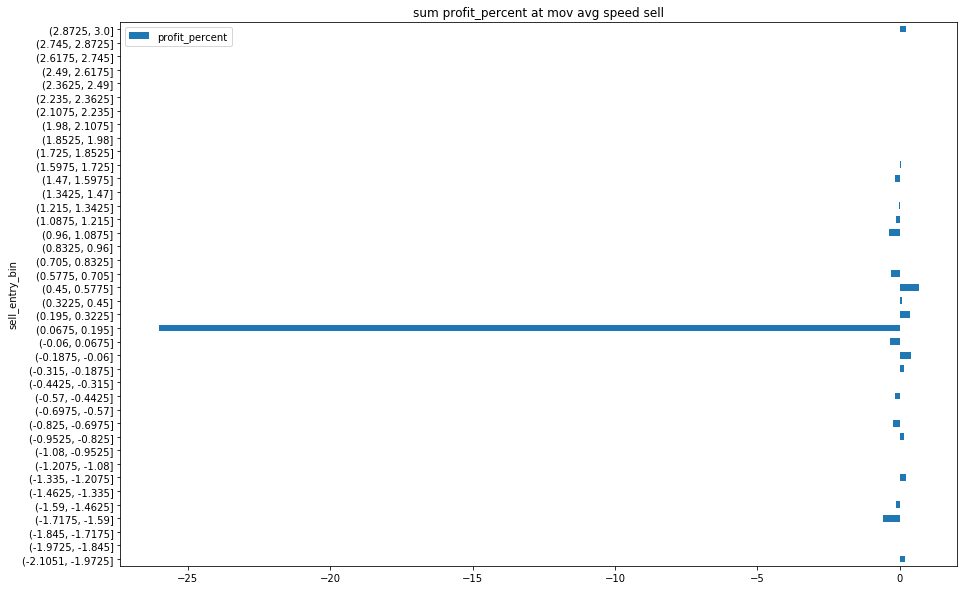

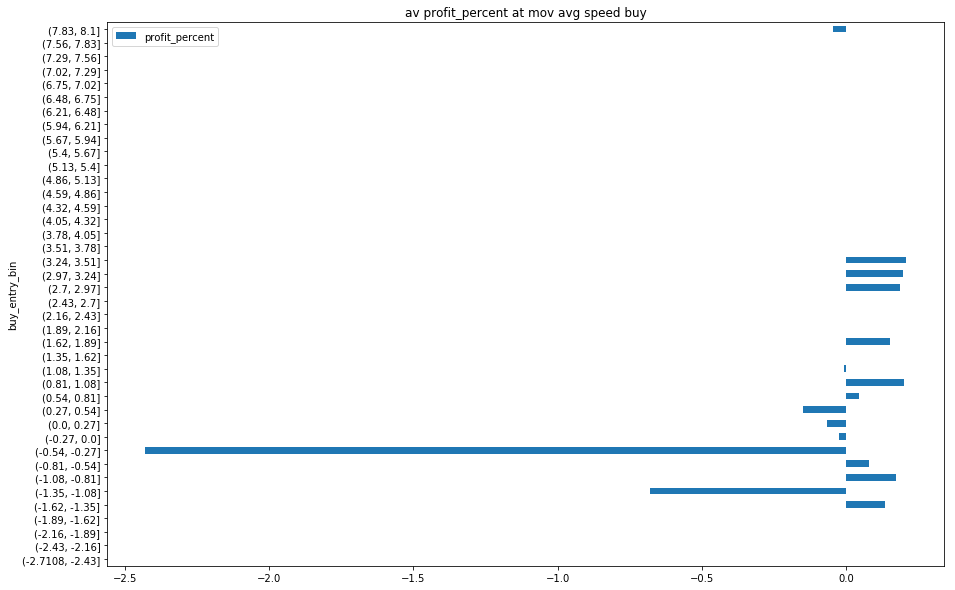

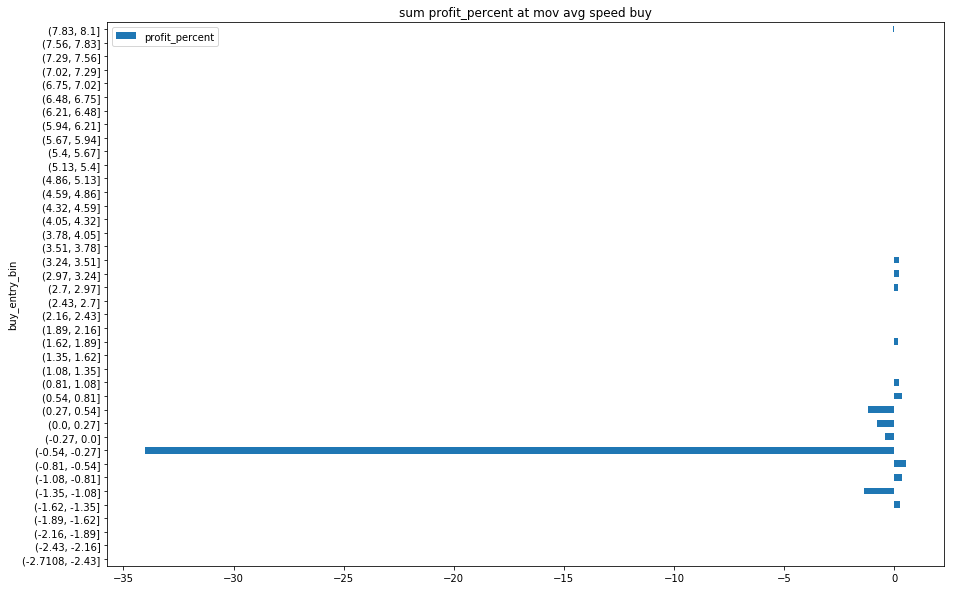

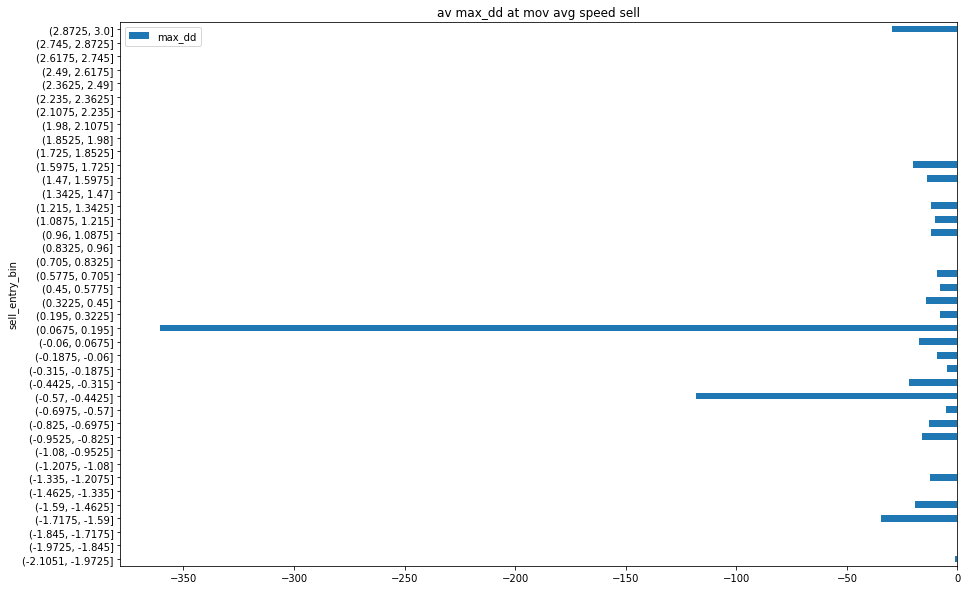

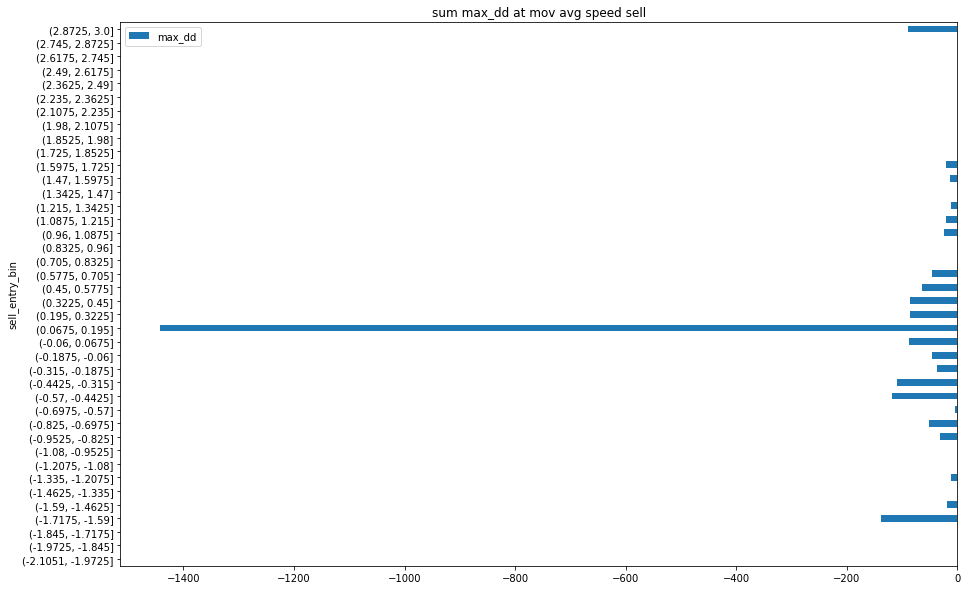

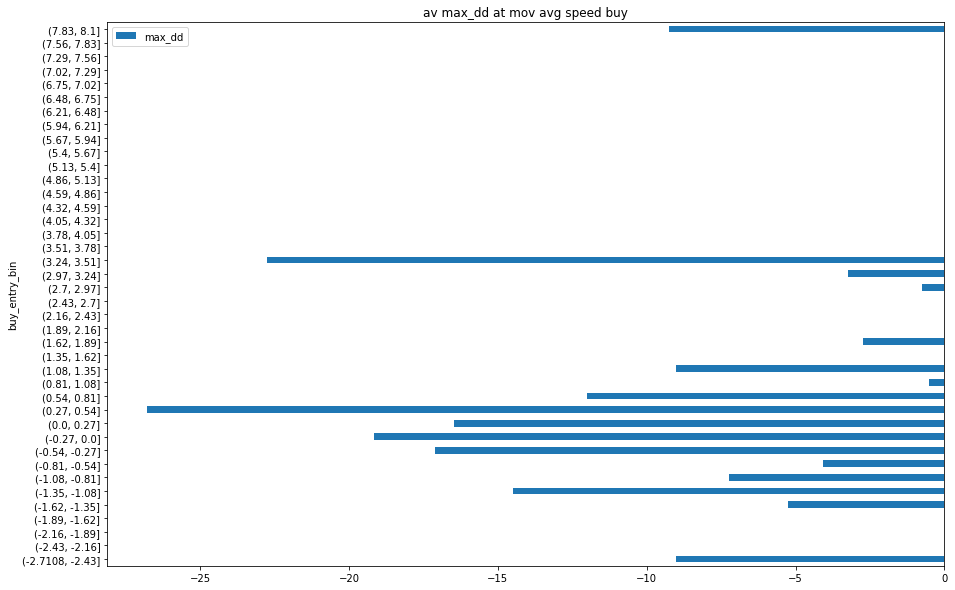

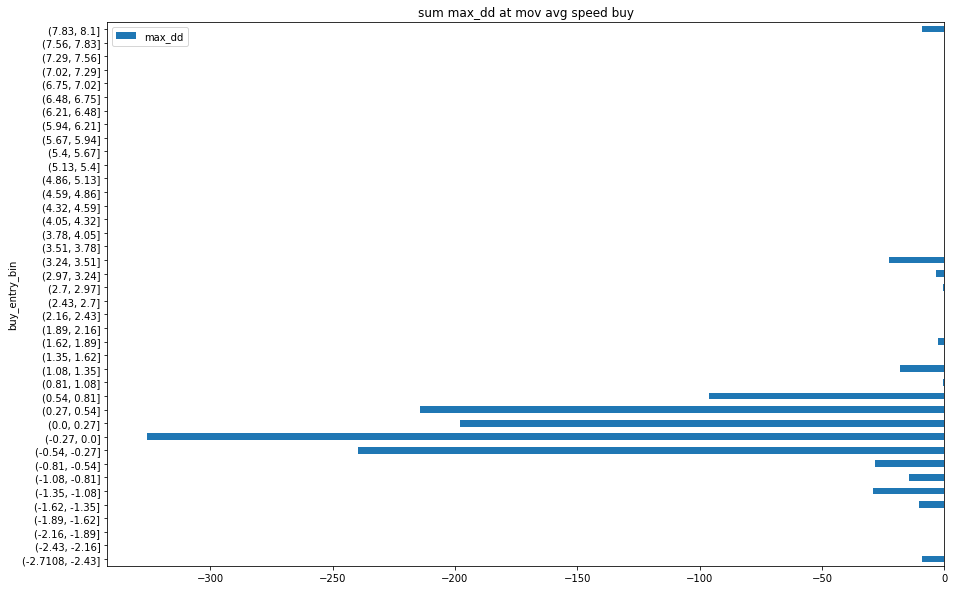

In [30]:
# group by sell price avg ###

seg1[["mov_avg_speed","profit_percent"]] = seg1[["mov_avg_speed","profit_percent"]].astype(float)
buy_trades_m = seg1[seg1["initial_side"]=="buy"]
sell_trades_m = seg1[seg1["initial_side"]=="sell"]

buy_trades_m = buy_trades_m.copy()
sell_trades_m = sell_trades_m.copy()

sell_scat = sell_trades_m.plot.scatter(x="mov_avg_speed",y="profit_percent")
#sell_scat.set_xlim(-0.001,0.0005) 
plt.title("sell trades, mov avg speed vs profit percent")
buy_scat = buy_trades_m.plot.scatter(x="mov_avg_speed",y="profit_percent")
#buy_scat.set_xlim(-0.0005,0.001) 
plt.title("buy trades, mov avg speed vs profit percent")

for variable in ["profit_percent","max_dd"]:
    sell_trades_m["sell_entry_bin"] = pd.cut(x = sell_trades_m["mov_avg_speed"],bins = 40,precision=4)
    sell_entry_group = sell_trades_m.groupby("sell_entry_bin").mean()
    sell_entry_group.plot.barh(y=variable,figsize=(15,10))
    plt.title("av "+variable+" at mov avg speed sell")
    
    # group by sell price sum ###
    sell_trades_m["sell_entry_bin"] = pd.cut(x = sell_trades_m["mov_avg_speed"],bins = 40,precision=4)
    sell_entry_group = sell_trades_m.groupby("sell_entry_bin").sum()
    sell_entry_group.plot.barh(y=variable,figsize=(15,10))
    plt.title("sum "+variable+" at mov avg speed sell")
    
    # group by buy price avg ###
    buy_trades_m["buy_entry_bin"] = pd.cut(x = buy_trades_m["mov_avg_speed"],bins = 40,precision=4)
    buy_entry_group = buy_trades_m.groupby("buy_entry_bin").mean()
    buy_entry_group.plot.barh(y=variable,figsize=(15,10))
    plt.title("av "+variable+" at mov avg speed buy")
    
    # group by buy price sum ###
    buy_trades_m["buy_entry_bin"] = pd.cut(x = buy_trades_m["mov_avg_speed"],bins = 40,precision=4)
    buy_entry_group = buy_trades_m.groupby("buy_entry_bin").sum()
    buy_entry_group.plot.barh(y=variable,figsize=(15,10))
    plt.title("sum "+variable+" at mov avg speed buy")

## Profit vs time in trade

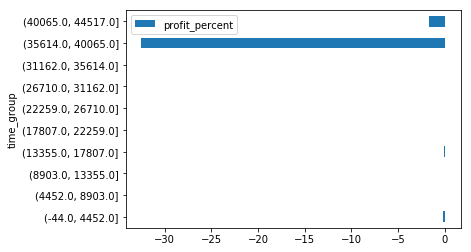

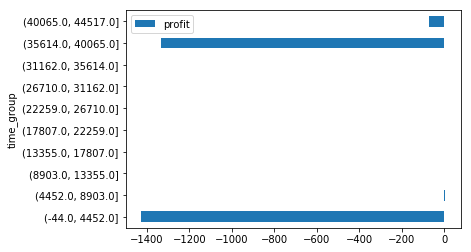

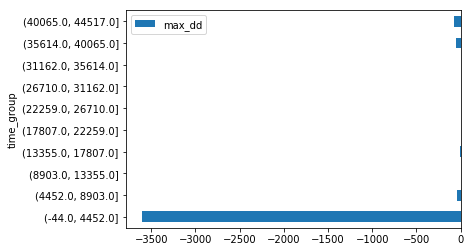

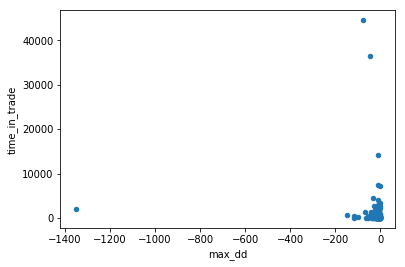

In [31]:
trades3["time_group"] = pd.cut(trades3["time_in_trade"],bins=10,precision=0)

time_in_trade_avg_group = trades3.groupby("time_group").mean()
time_in_trade_sum_group = trades3.groupby("time_group").sum()

time_in_trade_avg_group.plot.barh(y = "profit_percent")
time_in_trade_sum_group.plot.barh(y = "profit")
time_in_trade_sum_group.plot.barh(y = "max_dd")
trades3.plot.scatter(x="max_dd",y="time_in_trade")
#trades3

## Max DD vs profit percentage
### This should help us determine the best stop!

,dd_tot_profit,initial_side
max_dd_group,,
"(-1354.0, -1218.0]",-1286.0,1
"(-1218.0, -1082.0]",-0.0,0
"(-1082.0, -947.0]",-0.0,0
"(-947.0, -812.0]",-0.0,0
"(-812.0, -677.0]",-0.0,0
"(-677.0, -542.0]",-0.0,0
"(-542.0, -406.0]",-0.0,0
"(-406.0, -271.0]",-0.0,0
"(-271.0, -136.0]",-203.5,1


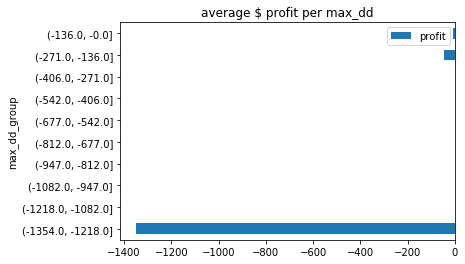

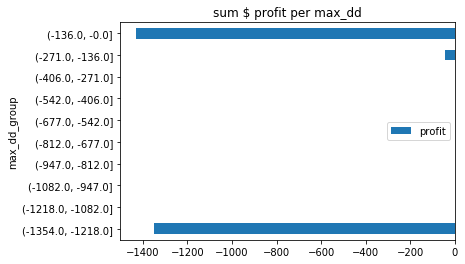

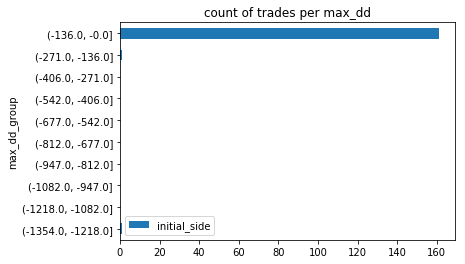

In [32]:
trades3["max_dd_group"] = pd.cut(trades3["max_dd"],bins=10,precision=0)

max_dd_avg_group = trades3.groupby("max_dd_group").mean()
max_dd_avg_group.plot.barh(y = "profit",title="average $ profit per max_dd")

max_dd_sum_group = trades3.groupby("max_dd_group").sum()
max_dd_sum_group.plot.barh(y = "profit",title="sum $ profit per max_dd")

max_dd_count_group = trades3.groupby("max_dd_group").count()
max_dd_count_group.plot.barh(y = "initial_side",title="count of trades per max_dd")

for index,row in max_dd_count_group.iterrows():
    max_dd_count_group.loc[index,"dd_tot_profit"] = index.mid*row["profit"]
max_dd_count_group[["dd_tot_profit","initial_side"]]
    



#trades3.plot.scatter(x="max_dd",y="profit")

In [33]:
print(len(seg1))

4965944


In [34]:
seg1.head()

,askPrice_x,askPrice_y,ask_size_x,ask_size_y,bidPrice_x,bidPrice_y,bid_size_x,bid_size_y,symbol_x,symbol_y,timestamp,sell_perp,buy_perp,mov_avg_speed_dup,spread_mid_avg_rolling,price_mid_avg,spread_mid_avg,sell_perp_band,buy_perp_band,sell_perp_boll,buy_perp_boll,working_bid(band),working_ask(band),perp_bid_ask_dup,fut_bid_ask_dup,sell_spread_price,buy_spread_price,buy_entry,close_time,comms,dd_of_target,fut_bid_ask,initial_side,max_dd,mov_avg_speed,open_time,perp_bid_ask,profit,profit_percent,revenue,revenue_of_target,sell_entry,target_size,time_in_trade,volatility
0,3681.5,3622.0,1500.0,98.0,3680.0,3621.5,120.0,267.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 02:40:24.194,58.0,60.0,-1.791038,63.046667,3652.125,57.25,68.0,58.0,72.5,54.0,3679.0,3690.0,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.5
1,3681.0,3622.0,20.0,98.0,3680.0,3621.5,120.0,267.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 02:40:24.389,58.0,59.5,-1.791038,62.931667,3652.125,57.25,68.0,58.0,72.0,54.0,3679.0,3690.0,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0
2,3681.0,3622.0,20.0,98.0,3680.0,3621.5,120.0,267.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 02:40:24.394,58.0,59.5,-1.791038,62.931667,3652.125,57.25,68.0,58.0,72.0,54.0,3679.0,3690.0,1.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0
3,3681.0,3622.0,20.0,98.0,3680.0,3621.5,120.0,267.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 02:40:24.589,58.0,59.5,-1.791038,62.931667,3652.125,57.25,68.0,58.0,72.0,54.0,3679.0,3690.0,1.0,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0
4,3681.0,3623.5,20.0,18.0,3680.0,3622.0,120.0,8.0,BTC-PERPETUAL,BTC-29MAR19,2019-01-01 02:40:24.614,56.5,59.0,-1.791038,62.931667,3652.125,57.25,68.0,58.0,72.5,54.0,3679.0,3690.0,1.0,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.5


In [35]:
start = datetime.datetime(2018,12,1)
end = datetime.datetime(2018,12,4)

plotter = seg1[(seg1["timestamp"]>start) & (seg1["timestamp"]<end)]
plotter.plot(x = "timestamp", y =["sell_perp","buy_perp","buy_perp_band","sell_perp_band"],figsize=(20,12))


TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
seg1.plot(x = "timestamp", y =["sell_perp","buy_perp","buy_perp_band","sell_perp_band"],figsize=(20,12))

#### take out times market was wide
#seg1["perp_spread"] = seg1["askPrice_x"] - seg1["bidPrice_x"]
#seg1["fut_spread"] = seg1["askPrice_y"] - seg1["bidPrice_y"]
#exp = seg1[(seg1["perp_spread"] <=0.5) & (seg1["fut_spread"] <=1)]
#exp.plot(x = "timestamp", y =["sell_perp","buy_perp","buy_perp_band","sell_perp_band"],figsize=(20,12))

In [ ]:
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)         # initiate notebook for offline plot

from plotly.graph_objs import *
import plotly.graph_objs as go

data = seg1 #.copy()

## for large data sets ###
#start = 30000
#sample_size = 40000
#end = min(len(data),start+sample_size)
#data = data[start:end]

#data = data[-5000:]

### by date ###
start = datetime.datetime(2019,1,7)
end = start + datetime.timedelta(hours=4)
data = data[(data["timestamp"]>start) & (data["timestamp"]<end)]

####################################

trace = go.Scatter(
    x = data["timestamp"],
    y = data["askPrice_x"],
    line = dict(width = 1,
                color = "green"),
    name = "askPrice buy perp"
)

trace3 = go.Scatter(
    x = data["timestamp"],
    y = data["bidPrice_x"],
    line = dict(width = 1,
                color = "red"),
    name = "bidPrice sell perp"
)

trace1 = go.Scatter(
    x = data["timestamp"],
    y = data["bidPrice_y"],
    line = dict(width = 1,
                color = "blue"),
    name = "bidPrice sell fut"
)
trace2 = go.Scatter(
    x = data["timestamp"],
    y = data["askPrice_y"],
    line = dict(width = 1,
                color = "orange"),
    name = "askPrice buy fut"
)

trace4 = go.Scatter(
    x = data["timestamp"],
    y = data["working_bid(band)"],
    line = dict(width = 1,
                color = "blue",
                dash = "dash"),
    name = "working_bid(band)"
)
trace5 = go.Scatter(
    x = data["timestamp"],
    y = data["working_ask(band)"],
    line = dict(width = 1,
                color = "blue",
                dash = "dash"),
    name = "working_ask(band)"
)


plot = [trace,trace1,trace2,trace3,trace4,trace5]
iplot(plot)


## buy sell bands
#trace0 = go.Scattergl(
#    x = data["timestamp"], 
#    y = data["buy_perp_boll"],
#    line = dict(
#           width = 2,
#           color = "red",
#           dash = "dash"),
#    name = "buy boll"
#)
#trace1 = go.Scattergl(
#    x = data["timestamp"],
#    y = data["sell_perp_boll"],
#    line = dict(
#           width = 2,
#           color = "red",
#           dash = "dash"),
#    name = "sell boll"
#)
trace2 = go.Scatter(
    x = data["timestamp"], 
    y = data["buy_perp_band"],
    name = "buy perp band",
    line = dict(
           width = 2,
           color= "blue")
)
trace3 = go.Scatter(
    x = data["timestamp"],
    y = data["sell_perp_band"],
    name = "sell perp band",
    line = dict(
           width = 2,
           color= "blue")
)
trace4 = go.Scatter(
    x = data["timestamp"], 
    y = data["sell_perp"],
    name = "sell perp",
    line = dict(
           width = 1,
           color = "orange"),
)
trace5 = go.Scatter(
    x = data["timestamp"], 
    y = data["buy_perp"],
    name = "buy perp",
    line = dict(
           width = 1,
           color = "green"),
)
trace6 = go.Scatter(
    x = data["timestamp"], 
    y = data["sell_spread_price"],
    name = "sell trade",
    mode = "markers",
    marker = dict(
           size = 8,
           color = "black"),
)
trace7 = go.Scatter(
    x = data["timestamp"], 
    y = data["buy_spread_price"],
    name = "buy trade",
    mode = "markers",
    marker = dict(
           size = 8,
           color = "purple"),
)

plot1 = [trace2,trace3,trace4,trace5,trace6,trace7]
iplot(plot1)